# Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**


# 0. Prepare data

In [1]:
import env 

private_key = env.key

In [2]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    import matplotlib.pyplot
    import pandas as pd
    import json
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv("./world.csv")
    
    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open("poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# pure coordinated in compressed representation, 2B per number -> 8MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float16) + np.random.normal(0, 0.01, np.array([v[0] for v in dataset], dtype=np.float16).shape)
N = len(dataset)
# free the memory
dataset = None
import gc
gc.collect()

0

Showing approximate dataset data distribution:

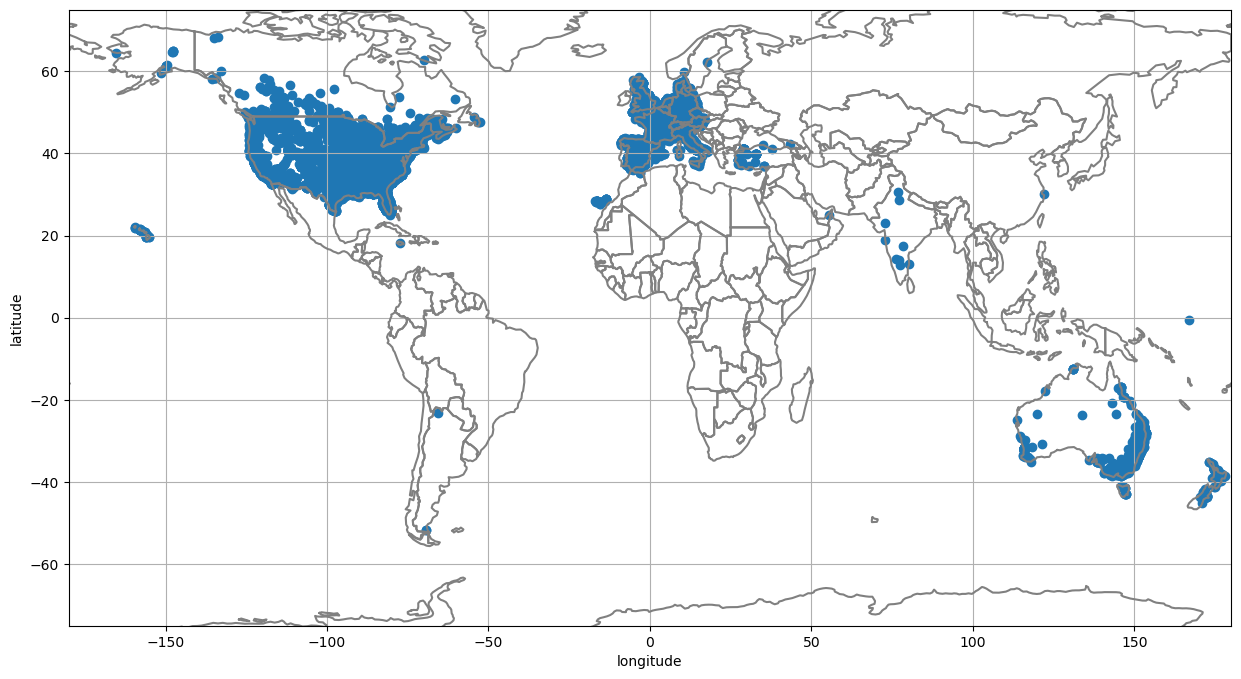

In [4]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [5]:
def split_shards(file, folder='shard', capacity=20000):
    import pickle, os, math, gc
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


# should return iterator, which goes through all elements, consequently opening files
# use ``yield`` operator to simplify your code
def iterate_dataset(items, folder="shard", capacity=20000):
    for i in range(0, items//capacity + 1):
        got = dataset_get(list(range(i * capacity, min((i + 1) * capacity, items))))
        for g in got:
            yield g

In [6]:
split_shards("poi_sample01.pickle")

asserts:

In [7]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [8]:
import numpy as np

for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i,:], dataset_get([i])[0][0], atol=5*1e-2), ""

In [9]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius. Clarification: for simplicity **radius is given in units of coordinates (degrees)**, not kilometers or meters.

In [10]:
from sklearn.neighbors import KDTree

def build_geospacial_index(points, leaf_size=5) -> KDTree:
    tree = KDTree(points, leaf_size=leaf_size)
    return tree


def kNN(query_point: list, k: int, index: KDTree) -> list:
    return index.query(query_point.reshape(1, -1), k=k, return_distance=False, sort_results=True)[0]
    pass


def inRadius(query_point: list, r: float, index: KDTree) -> list:
    return index.query_radius(query_point.reshape(1, -1), r=r)[0]
    pass

In [11]:
spaidx = build_geospacial_index(GEO)

In [12]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 10783, 14999, 15497, 16505, 22440, 23285, 24681, 26327]
[13, 145, 351, 2178, 3623, 7595, 9935, 10783, 11968, 12674, 14229, 14999, 15202, 15497, 16020, 16282, 16505, 16642, 16702, 20423, 21021, 21303, 22440, 23285, 24681, 26327, 27121, 27584]


[13, 145, 351, 11968, 15497, 16282, 21021, 23285, 24681, 26327]
[13, 145, 351, 15497, 23285, 24681, 26327]

## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. make sure they never coinside by adding insignificant noise)

Pass the assert to get full points.

In [13]:
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 1000, spaidx)
    assert (p in r), "Query did not return itself"

## 1.3. [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


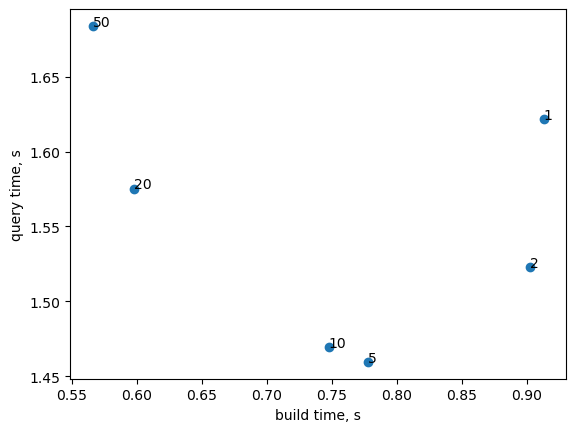

In [14]:
import random
import time
import matplotlib.pyplot as plt
import tqdm

queries = random.sample(range(N), 1000)
leaf_sizes = [1, 2, 5, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm.tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)
    
    start = time.time()
    for q in queries:
        d, r = spaidx.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [15]:
import numpy as np
from scipy.spatial import distance

# should return ids of the rows in this range
def get_in_range(ne, sw, idx, GEO) -> list:
    # diff counted using formalue from  https://en.wikipedia.org/wiki/Great-circle_distance#Formulae
    diff = np.arccos(np.sin(ne[1]) * np.sin(sw[1]) + np.cos(ne[1]) * np.cos(sw[1]) * np.cos(ne[0] - sw[0]))
    
    rads = idx.query_radius([[(ne[0]+sw[0])/2, (ne[1]+sw[1])/2]], r=diff, return_distance=True)
    # print(list(idx.data[rads[0][0][0]]))
    ret = []

    for r in rads[0][0]:
        # print( ne[0], list(idx.data[r])[0], sw[0], "...", ne[1], list(idx.data[r])[1] ,sw[1])
        if ne[0] >= list(idx.data[r])[0] >= sw[0] and ne[1]  >= list(idx.data[r])[1] >= sw[1]:
            ret.append(r)

    return ret

In [16]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [17]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 280 Park Ave
Starbucks, Coffee & Tea, . US, Manhattan, 655 Lexington Ave
Starbucks, Restaurant, . US, New York, 325 W 49 St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway


Starbucks, Restaurant, . US, New York, 325 W 49 St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway
Starbucks, Coffee & Tea, . US, New York, 787 7th Ave
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, Hilton New York Marketplace 1335 Avenue of the Americas
Starbucks, Coffee & Tea, . US, Manhattan, 280 Park Ave
Starbucks, Coffee & Tea, . US, Manhattan, 655 Lexington Ave
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 1372 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 151 W 34th St
Starbucks Coffee, Coffee & Tea, . US, New York, 1530 Broadway
Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks Coffee, Coffee & Tea, . US, New York, 450 W 33rd St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks, Restaurant, . US, Manhattan, 1585 Broadway

# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts to get full points.

In [18]:
import requests
import json

# this function returns a pair of tuples: NE and SW corners.
def get_town_range_coordinates(town: str, private_key: str) -> tuple:
    print(f"http://api.positionstack.com/v1/forward?access_key={private_key}&query={town}&bbox_module=1")
    api = f"http://api.positionstack.com/v1/forward?access_key={private_key}&query={town}&bbox_module=1"
    got = json.loads(requests.get(api).text)
    print(town, got)
    got = list(filter(lambda x: len(x["bbox_module"]) == 4, got["data"]))
    print(got)
    NE = got[0]["bbox_module"][2], got[0]["bbox_module"][3]
    SW = got[0]["bbox_module"][0], got[0]["bbox_module"][1]
    return NE, SW

If needed, request your key here: https://developers.google.com/maps/documentation/geocoding/get-api-key

Note, that from the **local machine** you may (!) need to have VPN enabled. For **colab** this should work smoothly.

In [19]:
my_google_maps_api_key = private_key

asserts:

In [20]:
p = get_town_range_coordinates('Pittsburgh downtown', my_google_maps_api_key)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

http://api.positionstack.com/v1/forward?access_key=15313f2ad21f544e551d713000257ce1&query=Pittsburgh downtown&bbox_module=1
Pittsburgh downtown {'data': [{'latitude': 40.450509, 'longitude': -79.936305, 'type': 'locality', 'name': 'Pittsburgh', 'number': None, 'postal_code': None, 'street': None, 'confidence': 1, 'region': 'Pennsylvania', 'region_code': 'PA', 'county': 'Allegheny County', 'locality': 'Pittsburgh', 'administrative_area': 'Pittsburgh', 'neighbourhood': None, 'country': 'United States', 'country_code': 'USA', 'continent': 'North America', 'label': 'Pittsburgh, PA, USA', 'bbox_module': [-80.095509, 40.361566, -79.865794, 40.501037]}, {'latitude': 40.443717, 'longitude': -80.002235, 'type': 'venue', 'name': 'Pittsburgh Renaissance', 'number': None, 'postal_code': None, 'street': None, 'confidence': 1, 'region': 'Pennsylvania', 'region_code': 'PA', 'county': 'Allegheny County', 'locality': 'Pittsburgh', 'administrative_area': 'Pittsburgh', 'neighbourhood': 'Downtown', 'count

## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries! Pass the assert to get the points.

In [21]:
# should return dataset indices
def get_in_town(town, index, GEO, maps_api_key) -> list:
    l, r = get_town_range_coordinates(town, maps_api_key)
    got = get_in_range(l, r, index, GEO)
    return got

In [22]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO, my_google_maps_api_key)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

http://api.positionstack.com/v1/forward?access_key=15313f2ad21f544e551d713000257ce1&query=Pittsburgh downtown&bbox_module=1
Pittsburgh downtown {'data': [{'latitude': 40.450509, 'longitude': -79.936305, 'type': 'locality', 'name': 'Pittsburgh', 'number': None, 'postal_code': None, 'street': None, 'confidence': 1, 'region': 'Pennsylvania', 'region_code': 'PA', 'county': 'Allegheny County', 'locality': 'Pittsburgh', 'administrative_area': 'Pittsburgh', 'neighbourhood': None, 'country': 'United States', 'country_code': 'USA', 'continent': 'North America', 'label': 'Pittsburgh, PA, USA', 'bbox_module': [-80.095509, 40.361566, -79.865794, 40.501037]}, {'latitude': 40.443717, 'longitude': -80.002235, 'type': 'venue', 'name': 'Pittsburgh Renaissance', 'number': None, 'postal_code': None, 'street': None, 'confidence': 1, 'region': 'Pennsylvania', 'region_code': 'PA', 'county': 'Allegheny County', 'locality': 'Pittsburgh', 'administrative_area': 'Pittsburgh', 'neighbourhood': 'Downtown', 'count

## 2.3. [5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [67]:
GEO_CACHE = None
RANGE_CACHE = None

In [68]:
def get_town_range_coordinates_cached(town: str, maps_key: str, index, GEO) -> tuple:
    global RANGE_CACHE
    try: len(RANGE_CACHE)
    except TypeError: RANGE_CACHE = dict()
    if len(RANGE_CACHE) != 0 and town in RANGE_CACHE:
        if town in RANGE_CACHE:
            print('CACHE HIT!')
            return RANGE_CACHE[town][0], RANGE_CACHE[town][1]
    else:
        print('CACHE MISS!')
        l, r = get_town_range_coordinates(town, maps_key)
        # got = get_in_range(l, r, index, GEO)
        RANGE_CACHE[town] = l, r
        return l, r
    pass


def get_in_town_cached(town: str, index, GEO, maps_key: str) -> list:
    global GEO_CACHE

    try: len(GEO_CACHE)
    except Exception: GEO_CACHE = dict()

    if len(GEO_CACHE) != 0 and town in GEO_CACHE:
        print('CACHE HIT!')
        if town in GEO_CACHE:
            return GEO_CACHE[town]
    else:
        print('CACHE MISS!')
        l, r = get_town_range_coordinates_cached(town, maps_key, index, GEO)
        got = get_in_range(l, r, index, GEO)
        GEO_CACHE[town] = got
        return got
    
    print("ASKJDHASJKL<DHAJKLSHDKLJASHD")
    pass

In [69]:
ids = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(ids)
ids = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(ids)

CACHE MISS!
CACHE MISS!
http://api.positionstack.com/v1/forward?access_key=15313f2ad21f544e551d713000257ce1&query=Boulder, CO&bbox_module=1
Boulder, CO {'data': [{'latitude': 40.016412, 'longitude': -105.259703, 'type': 'locality', 'name': 'Boulder', 'number': None, 'postal_code': None, 'street': None, 'confidence': 0.6, 'region': 'Colorado', 'region_code': 'CO', 'county': 'Boulder County', 'locality': 'Boulder', 'administrative_area': None, 'neighbourhood': None, 'country': 'United States', 'country_code': 'USA', 'continent': 'North America', 'label': 'Boulder, CO, USA', 'bbox_module': [-105.301758, 39.964069, -105.178355, 40.094551]}, {'latitude': 40.087912, 'longitude': -105.326561, 'type': 'county', 'name': 'Boulder County', 'number': None, 'postal_code': None, 'street': None, 'confidence': 1, 'region': 'Colorado', 'region_code': 'CO', 'county': 'Boulder County', 'locality': None, 'administrative_area': None, 'neighbourhood': None, 'country': 'United States', 'country_code': 'USA',

# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [26]:
!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 36.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [27]:
import spacy
nlp = spacy.load('en_core_web_md')
names = []

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait (and get **2 points**), but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices. Or maybe you want to use `fasttext` instead?

In [37]:
import numpy as np
from spacy.vocab import Vocab

# if you need most frequent english words for some reason.
WORDS = dict(map(lambda x:(x,False), [a.strip() for a in open('./words.txt', 'r').readlines()]))

def embed(text, nlp):
    if any(map(lambda t: t in nlp.vocab, text.split())):
        i = [nlp.vocab[word].vector for word in text.split() if word in nlp.vocab]
        mean = np.mean(i, axis=0)
        normix = np.linalg.norm(mean)
        return mean / normix
    return [0]*300


In [75]:
from tqdm import tqdm
import gc
import numpy as np

embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = (i, emb)

gc.collect()

  0%|          | 0/2173512 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

## 3.2. [10 points] Vector index

Here you build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib (please refer to the corresponding lab). Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements to get full points:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should use cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index right on the disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [32]:
embedding_index = None

In [39]:
import numpy as np
from annoy import AnnoyIndex
import os

f = 300

if os.path.exists("assignment_3.ann"):
    t = AnnoyIndex(f, 'angular')
    t.load('assignment_3.ann') # super fast, will just mmap the file
else:
    t = AnnoyIndex(f, 'angular')
    for i in range(len(embeddings)):
        t.add_item(i, embeddings[i])

    t.build(37)
    t.save('assignment_3.ann')

In [40]:
def get_vector_index():
    return t


def get_kNN_embeddings(embedding, k, index):
    return index.get_nns_by_vector(embedding, k)
    pass

In [41]:
embedding_index = get_vector_index()

In [42]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [73]:
def find(town, query) -> list:
    ids = get_in_town_cached(town, spaidx, GEO, my_google_maps_api_key)
    print("a", ids)
    knns = get_kNN_embeddings(embed(query, nlp), 1000, embedding_index)
    print("B", knns)
    ret= []
    for i in ids:
        if i in knns:
            ret.append(i)
    return ret
    # TODO should return list of data items, with coordinates and texts

In [74]:
items = find('Manhattan downtown', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])

CACHE HIT!
AAAA [1973793, 1451660, 1512640, 1929927, 1975159, 1522751, 1975164, 1532519, 1943520, 1539336, 1906327, 1929909, 1966032, 1514865, 1508871, 1488284, 1973822, 1973986, 1502256, 1455876, 1443255, 1960310, 1960368, 1943449, 1502846, 1527428, 1539960, 1965261, 1516301, 1527172, 1488945, 1966171, 1532671, 1510153, 1541513, 1504425, 1973831, 1531321, 1929512, 1508389, 1506081, 1513282, 1964985, 1966346, 1534136, 1524266, 1969750, 1973946, 1454217, 1960342, 1960355, 1467957, 1447012, 1442935, 1960476, 1462667, 1442003, 1471328, 1461476, 1463944, 1465818, 1458629, 1464702, 1468976, 1445627, 1454439, 1929200, 1466585, 1466405, 1451990, 1453565, 1455160, 1442780, 1454245, 1960306, 1432385, 1470233, 1452385, 1468320, 1448540, 1901141, 1966268, 1524509, 1969803, 1509709, 1965355, 1464209, 1913945, 1960298, 1447131, 1455735, 1445291, 1462433, 1464358, 1431889, 1443449, 1468497, 1511680, 1929569, 1965244, 1491941, 1969872, 1522698, 1542886, 1535477, 1929572, 1536545, 1541366, 1965295, 19

CACHE HIT!
((-73.9066509954, 40.8790380468), (-74.047729627, 40.6829169454))
CACHE HIT!
[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

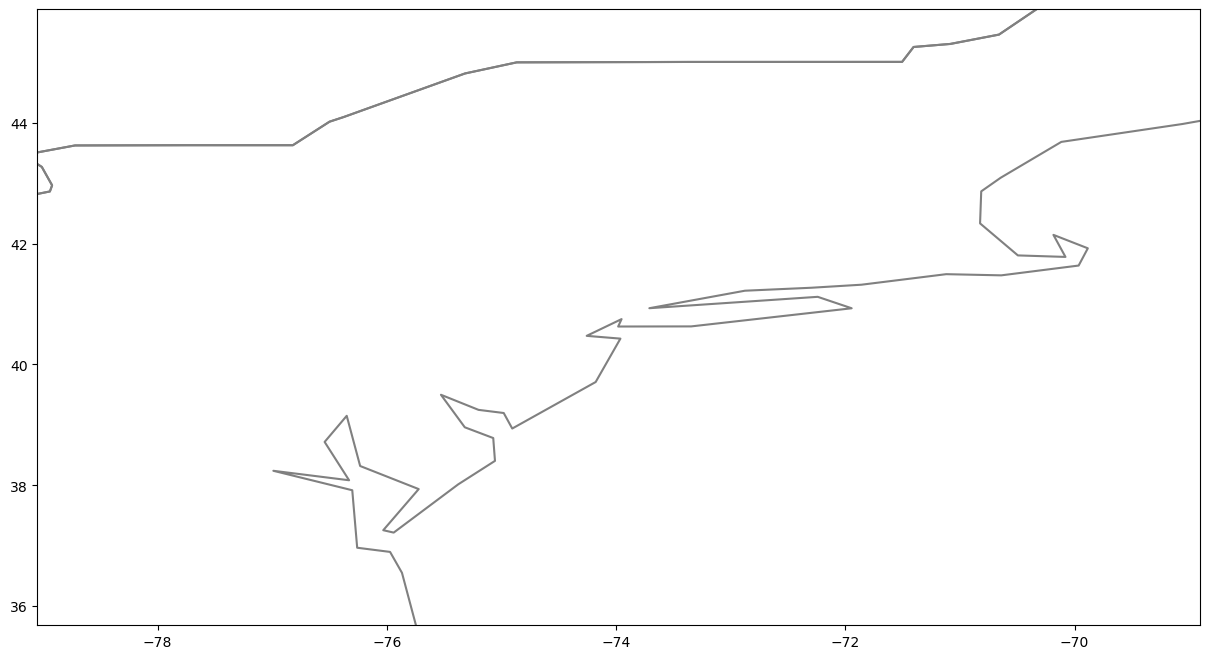

In [72]:
print(get_town_range_coordinates_cached('Manhattan downtown', my_google_maps_api_key, spaidx, GEO))
NE, SW = get_town_range_coordinates_cached('Manhattan downtown', my_google_maps_api_key, spaidx, GEO)
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
print(xy)
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()